# Final Project Submission

Please fill out:
* Student name: Hiten Patel 
* Student pace: Full Time Online 
* Scheduled project review date/time: 10/17: 10AM
* Instructor name: James Irving 
* Blog post URL: https://hpatel530.github.io/blog_number_4_by_hiten_patel


# Chicago Car Crash: Predicting the Cause of Traffic Accidents 

## Introduction 

# Obtain 

## Import Packages 

In [336]:
#!pip install scikit-learn==0.23.2

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, r2_score, recall_score, precision_score, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn import metrics  
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler



from sklearn.compose import ColumnTransformer
# from sklearn import set_config
# set_config(display='diagram')

#!pip install shap
import shap 
shap.initjs()

import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC

import warnings
warnings.filterwarnings('ignore')

## Functions 

In [337]:
def evaluate_classification(model, X_train_tf, X_test_tf, y_train, y_test, classes = None, 
                            normalize = 'true', cmap='ocean', label = ''):
    
    """Input a model, training data and test data to return sklearn metrics
        - Classification Report for training and test 
        - Confusion Matrix 
        - ROC Curve 
    """
    # retrieve predictions for train and test data 
    y_pred_train = model.predict(X_train_tf)
    y_pred_test = model.predict(X_test_tf)
    
    # print training classification report 
    header = label + " CLASSIFICATION REPORT TRAINING "
    dashes = "---" * 20
    print(dashes, header, dashes, sep='\n')
    print(classification_report(y_train, y_pred_train, target_names = classes))
    
    # display training figures 
    fig, axes = plt.subplots(figsize=(10,4), ncols=2)
    
    # confusion matrix 
    plot_confusion_matrix(model, X_train_tf, y_train, labels=classes, normalize = normalize,
                         cmap = cmap, ax=axes[0])
    
    axes[0].set(title = 'Confusion Matrix Training')
    
    # plot ROC curve 
    plot_roc_curve(model, X_train_tf, y_train, ax=axes[1])
    roc = axes[1]
    roc.legend()
    roc.plot([0,1], [0,1], ls=':')
    roc.grid()
    roc.set_title('Receiving Operator Characteristic Training')
    plt.show()
    
    # print testing classification report 
    header_ = label + " CLASSIFICATION REPORT TESTING "
    print(dashes, header_, dashes, sep='\n')
    print(classification_report(y_test, y_pred_test, target_names = classes))
    
    # display training figures 
    fig, axes = plt.subplots(figsize=(10,4), ncols=2)
    
    # confusion matrix 
    plot_confusion_matrix(model, X_test_tf, y_test,  labels=classes, normalize = normalize, 
                          cmap = cmap, ax=axes[0])
  
    
    axes[0].set(title = 'Confusion Matrix Testing')
    
    # plot ROC curve 
    plot_roc_curve(model, X_test_tf, y_test, ax=axes[1])
    roc = axes[1]
    roc.legend()
    roc.plot([0,1], [0,1], ls=':')
    roc.grid()
    roc.set_title('Receiving Operator Characteristic Test')
    plt.show()

## Import Data

### Data Source 1: crash 

In [338]:
# importing database one and observe 
pd.set_option('display.max_columns', None)
crash = pd.read_csv('https://data.cityofchicago.org/resource/85ca-t3if.csv')
print(crash.shape)
display(crash.head())
crash.info()

(1000, 49)


,crash_record_id,rd_no,crash_date_est_i,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,lane_cnt,alignment,roadway_surface_cond,road_defect,report_type,crash_type,intersection_related_i,private_property_i,hit_and_run_i,damage,date_police_notified,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,photos_taken_i,statements_taken_i,dooring_i,work_zone_i,work_zone_type,workers_present_i,num_units,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location
0,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,NaN,NaN,2020-10-15T00:45:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",2020-10-15T00:53:00.000,UNABLE TO DETERMINE,NOT APPLICABLE,441,E,63RD ST,312,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,5,10,41.780157,-87.614038,POINT (-87.614037584826 41.780157473915)
1,cb86d622709d797f6120f31de88256d8ae29eda16d3bbc...,NaN,NaN,2020-10-14T23:40:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"OVER $1,500",2020-10-14T23:42:00.000,UNABLE TO DETERMINE,NOT APPLICABLE,5499,S,COTTAGE GROVE AVE,233,NaN,NaN,NaN,NaN,NaN,NaN,1,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23,4,10,41.795054,-87.606065,POINT (-87.606065131251 41.795053706822)
2,e56551f10fbb1f3adfed04d54b924c7eb7bb8aa1731d73...,NaN,NaN,2020-10-14T22:30:00.000,30,STOP SIGN/FLASHER,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"$501 - $1,500",2020-10-14T23:00:00.000,IMPROPER OVERTAKING/PASSING,NOT APPLICABLE,5640,W,FULLERTON AVE,2515,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,22,4,10,41.924064,-87.767660,POINT (-87.767660486373 41.924064416379)
3,fc0b680577dcb56ed3ccdc0f005fe8fa36aee0a85e677f...,NaN,NaN,2020-10-14T22:29:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,NaN,N,"$501 - $1,500",2020-10-14T23:39:00.000,NOT APPLICABLE,NOT APPLICABLE,5900,S,CARPENTER ST,712,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22,4,10,41.786846,-87.651192,POINT (-87.651192389305 41.786845997049)
4,f1258057a85a5950f9044c98f462b73c2faf6b3cb396df...,NaN,NaN,2020-10-14T21:40:00.000,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),INJURY AND / OR TOW DUE TO CRASH,Y,NaN,NaN,"OVER $1,500",2020-10-14T23:00:00.000,NOT APPLICABLE,NOT APPLICABLE,7600,S,PEORIA ST,621,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,0.0,21,4,10,41.755974,-87.646752,POINT (-87.646751597184 41.755973580067)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   crash_record_id                1000 non-null   object 
 1   rd_no                          0 non-null      float64
 2   crash_date_est_i               70 non-null     object 
 3   crash_date                     1000 non-null   object 
 4   posted_speed_limit             1000 non-null   int64  
 5   traffic_control_device         1000 non-null   object 
 6   device_condition               1000 non-null   object 
 7   weather_condition              1000 non-null   object 
 8   lighting_condition             1000 non-null   object 
 9   first_crash_type               1000 non-null   object 
 10  trafficway_type                1000 non-null   object 
 11  lane_cnt                       0 non-null      float64
 12  alignment                      1000 non-null   ob

### Data Source 2: vehicle 


In [339]:
# importing database two and observe 
vehicle = pd.read_csv('https://data.cityofchicago.org/resource/68nd-jvt3.csv')
print(vehicle.shape)
display(vehicle.head())
vehicle.info()

(1000, 72)


,crash_unit_id,crash_record_id,rd_no,crash_date,unit_no,unit_type,num_passengers,vehicle_id,cmrc_veh_i,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,towed_i,fire_i,occupant_cnt,exceed_speed_limit_i,towed_by,towed_to,area_00_i,area_01_i,area_02_i,area_03_i,area_04_i,area_05_i,area_06_i,area_07_i,area_08_i,area_09_i,area_10_i,area_11_i,area_12_i,area_99_i,first_contact_point,cmv_id,usdot_no,ccmc_no,ilcc_no,commercial_src,gvwr,carrier_name,carrier_state,carrier_city,hazmat_placards_i,hazmat_name,un_no,hazmat_present_i,hazmat_report_i,hazmat_report_no,mcs_report_i,mcs_report_no,hazmat_vio_cause_crash_i,mcs_vio_cause_crash_i,idot_permit_no,wide_load_i,trailer1_width,trailer2_width,trailer1_length,trailer2_length,total_vehicle_length,axle_cnt,vehicle_config,cargo_body_type,load_type,hazmat_out_of_service_i,mcs_out_of_service_i,hazmat_class
0,976931,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,NaN,2020-10-15T00:45:00.000,1,DRIVER,NaN,925788.0,NaN,GENERAL MOTORS CORPORATION (GMC),ACADIA,AL,2020.0,NONE,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,976932,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,NaN,2020-10-15T00:45:00.000,2,DRIVER,NaN,925792.0,NaN,HYUNDAI,SONATA,IL,2017.0,NONE,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,SIDE-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,976899,cb86d622709d797f6120f31de88256d8ae29eda16d3bbc...,NaN,2020-10-14T23:40:00.000,1,DRIVER,NaN,925758.0,NaN,MERCURY,GRAND MARQUIS,IL,2007.0,UNKNOWN,PASSENGER,UNKNOWN/NA,N,UNKNOWN/NA,Y,NaN,1.0,NaN,E & R,pound 2,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,976892,e56551f10fbb1f3adfed04d54b924c7eb7bb8aa1731d73...,NaN,2020-10-14T22:30:00.000,1,DRIVER,NaN,925757.0,NaN,CHEVROLET,OTHER (EXPLAIN IN NARRATIVE),IL,2013.0,NONE,PASSENGER,PERSONAL,S,PASSING/OVERTAKING,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,976893,e56551f10fbb1f3adfed04d54b924c7eb7bb8aa1731d73...,NaN,2020-10-14T22:30:00.000,2,DRIVER,NaN,925759.0,NaN,TOYOTA,COROLLA,IL,2019.0,NONE,PASSENGER,PERSONAL,W,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIDE-RIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 72 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   crash_unit_id             1000 non-null   int64  
 1   crash_record_id           1000 non-null   object 
 2   rd_no                     0 non-null      float64
 3   crash_date                1000 non-null   object 
 4   unit_no                   1000 non-null   int64  
 5   unit_type                 1000 non-null   object 
 6   num_passengers            158 non-null    float64
 7   vehicle_id                971 non-null    float64
 8   cmrc_veh_i                14 non-null     object 
 9   make                      971 non-null    object 
 10  model                     971 non-null    object 
 11  lic_plate_state           873 non-null    object 
 12  vehicle_year              799 non-null    float64
 13  vehicle_defect            971 non-null    object 
 14  vehicle_t

### Data Source 3: person 

In [340]:
# importing database three and observe 
person = pd.read_csv('https://data.cityofchicago.org/resource/u6pd-qa9d.csv')
print(person.shape)
display(person.head())
person.info()

(1000, 30)


,person_id,person_type,crash_record_id,rd_no,vehicle_id,crash_date,seat_no,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,ejection,injury_classification,hospital,ems_agency,ems_run_no,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,bac_result_value,cell_phone_use
0,O976931,DRIVER,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,NaN,925788.0,2020-10-15T00:45:00.000,NaN,WALNUT CREEK,CA,94596.0,M,39.0,CA,C,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,DECLINED,NaN,NaN,OTHER,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O976932,DRIVER,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,NaN,925792.0,2020-10-15T00:45:00.000,NaN,CHICAGO,IL,60620.0,M,21.0,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,DECLINED,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O976899,DRIVER,cb86d622709d797f6120f31de88256d8ae29eda16d3bbc...,NaN,925758.0,2020-10-14T23:40:00.000,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O976892,DRIVER,e56551f10fbb1f3adfed04d54b924c7eb7bb8aa1731d73...,NaN,925757.0,2020-10-14T22:30:00.000,NaN,CHICAGO,IL,60634.0,F,30.0,IL,D,SAFETY BELT USED,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,IMPROPER PASSING,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O976893,DRIVER,e56551f10fbb1f3adfed04d54b924c7eb7bb8aa1731d73...,NaN,925759.0,2020-10-14T22:30:00.000,NaN,GLENVIEW,IL,60025.0,F,37.0,IL,D,SAFETY BELT USED,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   person_id              1000 non-null   object 
 1   person_type            1000 non-null   object 
 2   crash_record_id        1000 non-null   object 
 3   rd_no                  0 non-null      float64
 4   vehicle_id             974 non-null    float64
 5   crash_date             1000 non-null   object 
 6   seat_no                208 non-null    float64
 7   city                   729 non-null    object 
 8   state                  741 non-null    object 
 9   zipcode                671 non-null    float64
 10  sex                    987 non-null    object 
 11  age                    735 non-null    float64
 12  drivers_license_state  594 non-null    object 
 13  drivers_license_class  493 non-null    object 
 14  safety_equipment       1000 non-null   object 
 15  airba

### Merging Data = df 

In [341]:
# merging all three data sources into 1, observing shape and previewing data 
merged = pd.merge(left=crash, right = vehicle, left_on='crash_record_id', right_on="crash_record_id")
df = pd.merge(left=merged, right=person, left_on = 'vehicle_id', right_on='vehicle_id')
print(df.shape)
df.head()

(1728, 149)


,crash_record_id_x,rd_no_x,crash_date_est_i,crash_date_x,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,lane_cnt,alignment,roadway_surface_cond,road_defect,report_type,crash_type,intersection_related_i,private_property_i,hit_and_run_i,damage,date_police_notified,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,photos_taken_i,statements_taken_i,dooring_i,work_zone_i,work_zone_type,workers_present_i,num_units,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location,crash_unit_id,rd_no_y,crash_date_y,unit_no,unit_type,num_passengers,vehicle_id,cmrc_veh_i,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,towed_i,fire_i,occupant_cnt,exceed_speed_limit_i,towed_by,towed_to,area_00_i,area_01_i,area_02_i,area_03_i,area_04_i,area_05_i,area_06_i,area_07_i,area_08_i,area_09_i,area_10_i,area_11_i,area_12_i,area_99_i,first_contact_point,cmv_id,usdot_no,ccmc_no,ilcc_no,commercial_src,gvwr,carrier_name,carrier_state,carrier_city,hazmat_placards_i,hazmat_name,un_no,hazmat_present_i,hazmat_report_i,hazmat_report_no,mcs_report_i,mcs_report_no,hazmat_vio_cause_crash_i,mcs_vio_cause_crash_i,idot_permit_no,wide_load_i,trailer1_width,trailer2_width,trailer1_length,trailer2_length,total_vehicle_length,axle_cnt,vehicle_config,cargo_body_type,load_type,hazmat_out_of_service_i,mcs_out_of_service_i,hazmat_class,person_id,person_type,crash_record_id_y,rd_no,crash_date,seat_no,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,ejection,injury_classification,hospital,ems_agency,ems_run_no,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,bac_result_value,cell_phone_use
0,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,NaN,NaN,2020-10-15T00:45:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",2020-10-15T00:53:00.000,UNABLE TO DETERMINE,NOT APPLICABLE,441,E,63RD ST,312,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,5,10,41.780157,-87.614038,POINT (-87.614037584826 41.780157473915),976931,NaN,2020-10-15T00:45:00.000,1,DRIVER,NaN,925788.0,NaN,GENERAL MOTORS CORPORATION (GMC),ACADIA,AL,2020.0,NONE,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O976931,DRIVER,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,NaN,2020-10-15T00:45:00.000,NaN,WALNUT CREEK,CA,94596.0,M,39.0,CA,C,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,DECLINED,NaN,NaN,OTHER,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,NaN,NaN,2020-10-15T00:45:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",2020-10-15T00:53:00.000,UNABLE TO DETERMINE,NOT APPLICABLE,441,E,63RD ST,312,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,5,10,41.780157,-87.614038,POINT (-87.614037584826 41.780157473915),976932,NaN,2020-10-15T00:45:00.000,2,DRIVER,NaN,925792.0,NaN,HYUNDAI,SONATA,IL,2017.0,NONE,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,SIDE-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Scrub 

## Calculating Nulls/Column 

In [342]:
# calculating nulls
nulls = df.isna().sum()
null_percent = nulls[nulls>0] / len(df)
null_percent.to_frame('% Null').style.background_gradient(cmap='Reds')

,% Null
rd_no_x,1.000000
crash_date_est_i,0.931713
lane_cnt,1.000000
report_type,0.020255
intersection_related_i,0.642361
private_property_i,0.963542
hit_and_run_i,0.681134
photos_taken_i,0.995949
statements_taken_i,0.995370
dooring_i,0.968750


In [343]:
# extracting columns with excesssive nulls which is set at 95%
Index_label = null_percent[null_percent>.70].index.tolist()
Index_label

['rd_no_x',
 'crash_date_est_i',
 'lane_cnt',
 'private_property_i',
 'photos_taken_i',
 'statements_taken_i',
 'dooring_i',
 'work_zone_i',
 'work_zone_type',
 'workers_present_i',
 'rd_no_y',
 'num_passengers',
 'cmrc_veh_i',
 'towed_i',
 'fire_i',
 'exceed_speed_limit_i',
 'towed_by',
 'towed_to',
 'area_00_i',
 'area_01_i',
 'area_02_i',
 'area_03_i',
 'area_04_i',
 'area_05_i',
 'area_06_i',
 'area_07_i',
 'area_08_i',
 'area_09_i',
 'area_10_i',
 'area_11_i',
 'area_12_i',
 'area_99_i',
 'cmv_id',
 'usdot_no',
 'ccmc_no',
 'ilcc_no',
 'commercial_src',
 'gvwr',
 'carrier_name',
 'carrier_state',
 'carrier_city',
 'hazmat_placards_i',
 'hazmat_name',
 'un_no',
 'hazmat_present_i',
 'hazmat_report_i',
 'hazmat_report_no',
 'mcs_report_i',
 'mcs_report_no',
 'hazmat_vio_cause_crash_i',
 'mcs_vio_cause_crash_i',
 'idot_permit_no',
 'wide_load_i',
 'trailer1_width',
 'trailer2_width',
 'trailer1_length',
 'trailer2_length',
 'total_vehicle_length',
 'axle_cnt',
 'vehicle_config',
 'ca

## Dropping Columns w/ Excessive Nulls

In [344]:
# previewing shape, data and info 
df = df.drop(columns = Index_label)
print(df.shape)
display(df.head())
df.info()

(1728, 77)


,crash_record_id_x,crash_date_x,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,report_type,crash_type,intersection_related_i,hit_and_run_i,damage,date_police_notified,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,num_units,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location,crash_unit_id,crash_date_y,unit_no,unit_type,vehicle_id,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,occupant_cnt,first_contact_point,person_id,person_type,crash_record_id_y,crash_date,city,state,zipcode,sex,age,drivers_license_state,safety_equipment,airbag_deployed,ejection,injury_classification,hospital,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result
0,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,2020-10-15T00:45:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,"OVER $1,500",2020-10-15T00:53:00.000,UNABLE TO DETERMINE,NOT APPLICABLE,441,E,63RD ST,312,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,5,10,41.780157,-87.614038,POINT (-87.614037584826 41.780157473915),976931,2020-10-15T00:45:00.000,1,DRIVER,925788.0,GENERAL MOTORS CORPORATION (GMC),ACADIA,AL,2020.0,NONE,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,1.0,FRONT,O976931,DRIVER,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,2020-10-15T00:45:00.000,WALNUT CREEK,CA,94596.0,M,39.0,CA,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,DECLINED,OTHER,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED
1,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,2020-10-15T00:45:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,"OVER $1,500",2020-10-15T00:53:00.000,UNABLE TO DETERMINE,NOT APPLICABLE,441,E,63RD ST,312,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,5,10,41.780157,-87.614038,POINT (-87.614037584826 41.780157473915),976932,2020-10-15T00:45:00.000,2,DRIVER,925792.0,HYUNDAI,SONATA,IL,2017.0,NONE,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,1.0,SIDE-LEFT,O976932,DRIVER,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,2020-10-15T00:45:00.000,CHICAGO,IL,60620.0,M,21.0,IL,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,DECLINED,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED
2,cb86d622709d797f6120f31de88256d8ae29eda16d3bbc...,2020-10-14T23:40:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,"OVER $1,500",2020-10-14T23:42:00.000,UNABLE TO DETERMINE,NOT APPLICABLE,5499,S,COTTAGE GROVE AVE,233,1,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23,4,10,41.795054,-87.606065,POINT (-87.606065131251 41.795053706822),976899,2020-10-14T23:40:00.000,1,DRIVER,925758.0,MERCURY,GRAND MARQUIS,IL,2007.0,UNKNOWN,PASSENGER,UNKNOWN/NA,N,UNKNOWN/NA,1.0,FRONT,O976899,DRIVER,cb86d622709d797f6120f31de88256d8ae29eda16d3bbc...,2020-10-14T23:40:00.000,NaN,NaN,NaN,X,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED
3,e56551f10fbb1f3adfed04d54b924c7eb7bb8aa1731d73...,2020-10-14T22:30:00.000,30,STOP SIGN/FLASHER,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,NaN,"$501 - $1,500",2020-10-14T23:00:00.000,IMPROPER OVERTAKING/PASSIN

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728 entries, 0 to 1727
Data columns (total 77 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   crash_record_id_x              1728 non-null   object 
 1   crash_date_x                   1728 non-null   object 
 2   posted_speed_limit             1728 non-null   int64  
 3   traffic_control_device         1728 non-null   object 
 4   device_condition               1728 non-null   object 
 5   weather_condition              1728 non-null   object 
 6   lighting_condition             1728 non-null   object 
 7   first_crash_type               1728 non-null   object 
 8   trafficway_type                1728 non-null   object 
 9   alignment                      1728 non-null   object 
 10  roadway_surface_cond           1728 non-null   object 
 11  road_defect                    1728 non-null   object 
 12  report_type                    1693 non-null   o

## Dropping Irrelevant Columns 

In [345]:
# dropping following columns due to irrelevance in predicting the cause of car accidents 
# irrelevent columns were dropped due to column description
drop = ['report_type', 'crash_type', 'damage', 'date_police_notified', 'injuries_fatal', 
        'injuries_incapacitating', 'most_severe_injury','injuries_non_incapacitating',
        'injuries_reported_not_evident', 'injuries_no_indication', 'injuries_unknown', 'crash_date',
        'crash_date', 'ejection','injury_classification', 'hospital']

df = df.drop(columns = drop)
print(df.shape)
df.head()

(1728, 62)


,crash_record_id_x,crash_date_x,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,intersection_related_i,hit_and_run_i,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,num_units,injuries_total,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location,crash_unit_id,crash_date_y,unit_no,unit_type,vehicle_id,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,occupant_cnt,first_contact_point,person_id,person_type,crash_record_id_y,city,state,zipcode,sex,age,drivers_license_state,safety_equipment,airbag_deployed,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result
0,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,2020-10-15T00:45:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,UNABLE TO DETERMINE,NOT APPLICABLE,441,E,63RD ST,312,2,0.0,0,5,10,41.780157,-87.614038,POINT (-87.614037584826 41.780157473915),976931,2020-10-15T00:45:00.000,1,DRIVER,925788.0,GENERAL MOTORS CORPORATION (GMC),ACADIA,AL,2020.0,NONE,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,1.0,FRONT,O976931,DRIVER,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,WALNUT CREEK,CA,94596.0,M,39.0,CA,SAFETY BELT USED,DID NOT DEPLOY,OTHER,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED
1,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,2020-10-15T00:45:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,UNABLE TO DETERMINE,NOT APPLICABLE,441,E,63RD ST,312,2,0.0,0,5,10,41.780157,-87.614038,POINT (-87.614037584826 41.780157473915),976932,2020-10-15T00:45:00.000,2,DRIVER,925792.0,HYUNDAI,SONATA,IL,2017.0,NONE,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,1.0,SIDE-LEFT,O976932,DRIVER,e7ebf3c521b989db35c15ef27c140ce262ea60fb0b42cd...,CHICAGO,IL,60620.0,M,21.0,IL,SAFETY BELT USED,DID NOT DEPLOY,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED
2,cb86d622709d797f6120f31de88256d8ae29eda16d3bbc...,2020-10-14T23:40:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,UNABLE TO DETERMINE,NOT APPLICABLE,5499,S,COTTAGE GROVE AVE,233,1,0.0,23,4,10,41.795054,-87.606065,POINT (-87.606065131251 41.795053706822),976899,2020-10-14T23:40:00.000,1,DRIVER,925758.0,MERCURY,GRAND MARQUIS,IL,2007.0,UNKNOWN,PASSENGER,UNKNOWN/NA,N,UNKNOWN/NA,1.0,FRONT,O976899,DRIVER,cb86d622709d797f6120f31de88256d8ae29eda16d3bbc...,NaN,NaN,NaN,X,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED
3,e56551f10fbb1f3adfed04d54b924c7eb7bb8aa1731d73...,2020-10-14T22:30:00.000,30,STOP SIGN/FLASHER,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,IMPROPER OVERTAKING/PASSING,NOT APPLICABLE,5640,W,FULLERTON AVE,2515,2,0.0,22,4,10,41.924064,-87.767660,POINT (-87.767660486373 41.924064416379),976892,2020-10-14T22:30:00.000,1,DRIVER,925757.0,CHEVROLET,OTHER (EXPLAIN IN NARRATIVE),IL,2013.0,NONE,PASSENGER,PERSONAL,S,PASSING/OVERTAKING,1.0,OTHER,O976892,DRIVER,e56551f10fbb1f3adfed04d54b924c7eb7bb8aa1731d73...,CHICAGO,IL,60634.0,F,30.0,IL,SAFETY BELT USED,NOT APPLICABLE,IMPROPER PASSING,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED
4,e56551f10fbb1f3adfed04d54b924c7eb7bb8aa1731d73...,2020-10-14T22:30:00.000,30,STOP SIGN/FLASHER,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NaN,IMPROPER OVERTAKING/PASSING,NOT APPLICABLE,5640,W,FULLERTON AVE,2515,2,0.0,22,4,10,41.924064,-87.767660,POINT (-87.767660486373 41.924064416379),976893,2020-10-14T22:30:00.000,2,DRIVER,925759.0,TOYOTA,COROLLA,IL,2019.0,NONE,PASSENGE

In [346]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728 entries, 0 to 1727
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   crash_record_id_x        1728 non-null   object 
 1   crash_date_x             1728 non-null   object 
 2   posted_speed_limit       1728 non-null   int64  
 3   traffic_control_device   1728 non-null   object 
 4   device_condition         1728 non-null   object 
 5   weather_condition        1728 non-null   object 
 6   lighting_condition       1728 non-null   object 
 7   first_crash_type         1728 non-null   object 
 8   trafficway_type          1728 non-null   object 
 9   alignment                1728 non-null   object 
 10  roadway_surface_cond     1728 non-null   object 
 11  road_defect              1728 non-null   object 
 12  intersection_related_i   618 non-null    object 
 13  hit_and_run_i            551 non-null    object 
 14  prim_contributory_cause 

## Dropping Redundant Columns

In [347]:
# dropping redundant columns, previewing shape, data and info 
drop = ['crash_record_id_x', 'crash_date_x', 'alignment', 'intersection_related_i', 'sec_contributory_cause',
        'num_units','crash_unit_id', 'vehicle_id', 'person_id', "crash_record_id_y", 'street_no', 'street_direction',
       'street_name', 'location', 'zipcode', 'crash_month', 'latitude', 'longitude', 'crash_date_y', 'unit_no',
       'model', 'vehicle_year', 'vehicle_use', 'travel_direction', 'maneuver', 'occupant_cnt', 'first_contact_point',
       'lic_plate_state', 'city', 'drivers_license_state']
df = df.drop(columns=drop)
print(df.shape)
display(df.head())
df.info()

(1728, 32)


,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,roadway_surface_cond,road_defect,hit_and_run_i,prim_contributory_cause,beat_of_occurrence,injuries_total,crash_hour,crash_day_of_week,unit_type,make,vehicle_defect,vehicle_type,person_type,state,sex,age,safety_equipment,airbag_deployed,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result
0,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,DRY,NO DEFECTS,NaN,UNABLE TO DETERMINE,312,0.0,0,5,DRIVER,GENERAL MOTORS CORPORATION (GMC),NONE,PASSENGER,DRIVER,CA,M,39.0,SAFETY BELT USED,DID NOT DEPLOY,OTHER,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED
1,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,DRY,NO DEFECTS,NaN,UNABLE TO DETERMINE,312,0.0,0,5,DRIVER,HYUNDAI,NONE,PASSENGER,DRIVER,IL,M,21.0,SAFETY BELT USED,DID NOT DEPLOY,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED
2,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,DRY,NO DEFECTS,NaN,UNABLE TO DETERMINE,233,0.0,23,4,DRIVER,MERCURY,UNKNOWN,PASSENGER,DRIVER,NaN,X,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED
3,30,STOP SIGN/FLASHER,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),DRY,NO DEFECTS,NaN,IMPROPER OVERTAKING/PASSING,2515,0.0,22,4,DRIVER,CHEVROLET,NONE,PASSENGER,DRIVER,IL,F,30.0,SAFETY BELT USED,NOT APPLICABLE,IMPROPER PASSING,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED
4,30,STOP SIGN/FLASHER,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),DRY,NO DEFECTS,NaN,IMPROPER OVERTAKING/PASSING,2515,0.0,22,4,DRIVER,TOYOTA,NONE,PASSENGER,DRIVER,IL,F,37.0,SAFETY BELT USED,NOT APPLICABLE,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728 entries, 0 to 1727
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   posted_speed_limit       1728 non-null   int64  
 1   traffic_control_device   1728 non-null   object 
 2   device_condition         1728 non-null   object 
 3   weather_condition        1728 non-null   object 
 4   lighting_condition       1728 non-null   object 
 5   first_crash_type         1728 non-null   object 
 6   trafficway_type          1728 non-null   object 
 7   roadway_surface_cond     1728 non-null   object 
 8   road_defect              1728 non-null   object 
 9   hit_and_run_i            551 non-null    object 
 10  prim_contributory_cause  1728 non-null   object 
 11  beat_of_occurrence       1728 non-null   int64  
 12  injuries_total           1728 non-null   float64
 13  crash_hour               1728 non-null   int64  
 14  crash_day_of_week       

## Inspecting Values per Column

In [348]:
for col in df.columns:
    try:
        print(col, df[col].value_counts()[:10])
    except:
        print(col, df[col].value_counts())
        # If there aren't 5+ unique values for a column the first print statement
        # will throw an error for an invalid idx slice
    print('\n') # Break up the output between columns

posted_speed_limit 30    1312
35     108
20     107
25      70
10      70
15      28
40      17
45       6
5        3
55       2
Name: posted_speed_limit, dtype: int64


traffic_control_device NO CONTROLS          864
TRAFFIC SIGNAL       482
STOP SIGN/FLASHER    281
UNKNOWN               65
OTHER                 32
YIELD                  3
SCHOOL ZONE            1
Name: traffic_control_device, dtype: int64


device_condition NO CONTROLS               856
FUNCTIONING PROPERLY      682
UNKNOWN                   141
OTHER                      43
FUNCTIONING IMPROPERLY      4
NOT FUNCTIONING             2
Name: device_condition, dtype: int64


weather_condition CLEAR              1512
RAIN                124
CLOUDY/OVERCAST      64
UNKNOWN              22
OTHER                 6
Name: weather_condition, dtype: int64


lighting_condition DAYLIGHT                  1194
DARKNESS, LIGHTED ROAD     355
DAWN                        63
DARKNESS                    54
DUSK                        43

## Dropping Columns

In [349]:
# prim_contributory_cause - officer's judgement
# make - irrelevant 
# vehicle_defect - most values are none/unknown
# person_type - redundant 
# state - irrelevant 
# driver_action - irrelevant 
# physical_condition - irrelevant 
# pedpedal_action - irrelevant
# pedpedal_location - irrelevant 
# bac_result - most tests not administered 

drop = ['prim_contributory_cause', 'vehicle_defect', 'make', 'person_type', 'state', 'driver_action',
       'physical_condition', 'pedpedal_action', 'pedpedal_location', 'bac_result']
df = df.drop(columns=drop)
print(df.shape)
display(df.head())
df.info()

(1728, 22)


,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,roadway_surface_cond,road_defect,hit_and_run_i,beat_of_occurrence,injuries_total,crash_hour,crash_day_of_week,unit_type,vehicle_type,sex,age,safety_equipment,airbag_deployed,driver_vision,pedpedal_visibility
0,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,DRY,NO DEFECTS,NaN,312,0.0,0,5,DRIVER,PASSENGER,M,39.0,SAFETY BELT USED,DID NOT DEPLOY,NOT OBSCURED,NaN
1,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,DRY,NO DEFECTS,NaN,312,0.0,0,5,DRIVER,PASSENGER,M,21.0,SAFETY BELT USED,DID NOT DEPLOY,NOT OBSCURED,NaN
2,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,DRY,NO DEFECTS,NaN,233,0.0,23,4,DRIVER,PASSENGER,X,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NaN
3,30,STOP SIGN/FLASHER,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),DRY,NO DEFECTS,NaN,2515,0.0,22,4,DRIVER,PASSENGER,F,30.0,SAFETY BELT USED,NOT APPLICABLE,UNKNOWN,NaN
4,30,STOP SIGN/FLASHER,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),DRY,NO DEFECTS,NaN,2515,0.0,22,4,DRIVER,PASSENGER,F,37.0,SAFETY BELT USED,NOT APPLICABLE,NOT OBSCURED,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728 entries, 0 to 1727
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   posted_speed_limit      1728 non-null   int64  
 1   traffic_control_device  1728 non-null   object 
 2   device_condition        1728 non-null   object 
 3   weather_condition       1728 non-null   object 
 4   lighting_condition      1728 non-null   object 
 5   first_crash_type        1728 non-null   object 
 6   trafficway_type         1728 non-null   object 
 7   roadway_surface_cond    1728 non-null   object 
 8   road_defect             1728 non-null   object 
 9   hit_and_run_i           551 non-null    object 
 10  beat_of_occurrence      1728 non-null   int64  
 11  injuries_total          1728 non-null   float64
 12  crash_hour              1728 non-null   int64  
 13  crash_day_of_week       1728 non-null   int64  
 14  unit_type               1728 non-null   

## Simplifying Categorical Columns 

In [301]:
df.crash_hour.value_counts()

15    227
17    194
16    166
14    144
19    133
18    123
20    117
7     102
13    100
11     98
12     55
21     47
0      46
6      40
8      26
22     26
9      25
23     21
10     15
5      11
4       4
2       4
1       3
3       1
Name: crash_hour, dtype: int64

In [284]:
df.crash_day_of_week.value_counts()

3    661
4    590
2    475
5      2
Name: crash_day_of_week, dtype: int64

In [302]:
df.age.value_counts()

54.0    69
36.0    68
51.0    65
28.0    52
20.0    50
        ..
86.0     1
13.0     1
3.0      1
7.0      1
73.0     1
Name: age, Length: 80, dtype: int64

### Bin 'posted_speed_limit'

In [303]:
df.posted_speed_limit.value_counts()

30    1312
35     108
20     107
25      70
10      70
15      28
40      17
45       6
5        3
55       2
24       2
0        2
34       1
Name: posted_speed_limit, dtype: int64

### Cleaning traffic_control_device

In [304]:
df.traffic_control_device.value_counts()

NO CONTROLS          864
TRAFFIC SIGNAL       482
STOP SIGN/FLASHER    281
UNKNOWN               65
OTHER                 32
YIELD                  3
SCHOOL ZONE            1
Name: traffic_control_device, dtype: int64

In [305]:
traffic_control_map = {'NO CONTROLS': 'NO CONTROLS',
                      'TRAFFIC SIGNAL': 'TRAFFIC SIGNAL/SIGN',
                      'STOP SIGN/FLASHER': 'TRAFFIC SIGNAL/SIGN',
                      'UNKNOWN': 'UNKNOWN/OTHER',
                      'OTHER': 'UNKNOWN/OTHER',
                      'YIELD': 'UNKNOWN/OTHER',
                      'SCHOOL ZONE' : 'UNKNOWN/OTHER'}

df.traffic_control_device = df.traffic_control_device.map(traffic_control_map)
df.traffic_control_device.value_counts()

NO CONTROLS            864
TRAFFIC SIGNAL/SIGN    763
UNKNOWN/OTHER          101
Name: traffic_control_device, dtype: int64

### Cleaning device_condition


In [306]:
df.device_condition.value_counts()

NO CONTROLS               856
FUNCTIONING PROPERLY      682
UNKNOWN                   141
OTHER                      43
FUNCTIONING IMPROPERLY      4
NOT FUNCTIONING             2
Name: device_condition, dtype: int64

In [307]:
device_map = {'NO CONTROLS': 'NO CONTROLS',
                      'FUNCTIONING PROPERLY': 'FUNCTIONING PROPERLY',
                      'UNKNOWN': 'NOT FUNCTIONING/UNKNOWN',
                      'OTHER': 'NOT FUNCTIONING/UNKNOWN',
                      'FUNCTIONING IMPROPERLY': 'NOT FUNCTIONING/UNKNOWN',
                      'NOT FUNCTIONING ': 'NOT FUNCTIONING/UNKNOWN'}

df.device_condition = df.device_condition.map(device_map)
df.device_condition.value_counts()

NO CONTROLS                856
FUNCTIONING PROPERLY       682
NOT FUNCTIONING/UNKNOWN    188
Name: device_condition, dtype: int64

### Cleaning weather_condition

In [308]:
df.weather_condition.value_counts()

CLEAR              1512
RAIN                124
CLOUDY/OVERCAST      64
UNKNOWN              22
OTHER                 6
Name: weather_condition, dtype: int64

In [309]:
weather_map = {'CLEAR': 'CLEAR',
                'RAIN': 'RAIN/CLOUDY/OTHER',
                'CLOUDY/OVERCAST': 'RAIN/CLOUDY/OTHER',
                'UNKNOWN': 'RAIN/CLOUDY/OTHER',
                'OTHER ': 'RAIN/CLOUDY/OTHER'}

df.weather_condition = df.weather_condition.map(weather_map)
df.weather_condition.value_counts()

CLEAR                1512
RAIN/CLOUDY/OTHER     210
Name: weather_condition, dtype: int64

### Cleaning first_crash_type

In [310]:
df.first_crash_type.value_counts()

PEDESTRIAN                      433
PEDALCYCLIST                    321
REAR END                        246
SIDESWIPE SAME DIRECTION        168
TURNING                         168
ANGLE                           151
PARKED MOTOR VEHICLE            146
FIXED OBJECT                     40
REAR TO SIDE                     14
SIDESWIPE OPPOSITE DIRECTION     13
REAR TO FRONT                    12
HEAD ON                           7
OTHER OBJECT                      4
REAR TO REAR                      4
OTHER NONCOLLISION                1
Name: first_crash_type, dtype: int64

In [311]:
crash_map = {'PEDESTRIAN': 'PED/CYCLIST',
                'PEDALCYCLIST': 'PED/CYCLIST',
                'REAR END': 'REAR END',
                'SIDESWIPE SAME DIRECTION': 'SIDESWIPE',
                'TURNING': 'TURNING/ANGLE',
                'ANGLE': 'TURNING/ANGLE',
                'PARKED MOTOR VEHICLE': 'PARKED/FIXED',
                'FIXED OBJECT': 'PARKED/FIXED',
                'REAR TO SIDE': 'OTHER',
                'SIDESWIPE OPPOSITE DIRECTION ': 'SIDESWIPE',
                'HEAD ON': 'OTHER',
                'OTHER OBJECT': 'OTHER',
                'REAR TO REAR': 'OTHER',
                'OTHER NONCOLLISION': 'OTHER'}

df.first_crash_type = df.first_crash_type.map(crash_map)
df.first_crash_type.value_counts()

PED/CYCLIST      754
TURNING/ANGLE    319
REAR END         246
PARKED/FIXED     186
SIDESWIPE        168
OTHER             30
Name: first_crash_type, dtype: int64

In [312]:
df.trafficway_type.value_counts()

NOT DIVIDED                        736
DIVIDED - W/MEDIAN (NOT RAISED)    290
ONE-WAY                            196
FOUR WAY                           153
PARKING LOT                         99
DIVIDED - W/MEDIAN BARRIER          74
ALLEY                               39
OTHER                               36
CENTER TURN LANE                    32
Y-INTERSECTION                      27
T-INTERSECTION                      26
UNKNOWN                             15
NOT REPORTED                         3
UNKNOWN INTERSECTION TYPE            2
Name: trafficway_type, dtype: int64

In [313]:
traffic_map = {'NOT DIVIDED': 'NOT DIVIDED',
                'DIVIDED - W/MEDIAN (NOT RAISED)': 'DIVIDED',
                'ONE-WAY': 'ONE-WAY',
                'FOUR WAY': 'FOUR WAY',
                'PARKING LOT': 'PARKING LOT',
                'DIVIDED - W/MEDIAN BARRIER': 'DIVIDED',
                'ALLEY': 'ALLEY/OTHER',
                'OTHER': 'ALLEY/OTHER',
                'CENTER TURN LANE': 'ALLEY/OTHER',
                'Y-INTERSECTION': 'ALLEY/OTHER',
                'T-INTERSECTION': 'ALLEY/OTHER',
                'UNKNOWN': 'UNKNOWN',
                'NOT REPORTED': 'UNKNOWN',
                'UNKNOWN INTERSECTION TYPE': 'UNKNOWN'}

df.trafficway_type = df.trafficway_type.map(traffic_map)
df.trafficway_type.value_counts()

NOT DIVIDED    736
DIVIDED        364
ONE-WAY        196
ALLEY/OTHER    160
FOUR WAY       153
PARKING LOT     99
UNKNOWN         20
Name: trafficway_type, dtype: int64

### Cleaning road_defect

In [314]:
df.road_defect.value_counts()

NO DEFECTS         1380
UNKNOWN             338
OTHER                 6
SHOULDER DEFECT       4
Name: road_defect, dtype: int64

In [315]:
defect_map = {'NO DEFECTS': 'NO DEFECTS',
                'UNKNOWN': 'UNKNOWN/OTHER',
                'OTHER': 'UNKNOWN/OTHER',
                'SHOULDER DEFECT': 'UNKNOWN/OTHER'}

df.road_defect = df.road_defect.map(defect_map)
df.road_defect.value_counts()

NO DEFECTS       1380
UNKNOWN/OTHER     348
Name: road_defect, dtype: int64

### Cleaning vehicle_type

In [273]:
df.vehicle_type.value_counts()

PASSENGER                         654
SPORT UTILITY VEHICLE (SUV)       118
UNKNOWN/NA                         96
VAN/MINI-VAN                       38
PICKUP                             19
OTHER                              17
TRACTOR W/ SEMI-TRAILER             9
TRUCK - SINGLE UNIT                 8
BUS UP TO 15 PASS.                  5
BUS OVER 15 PASS.                   3
SINGLE UNIT TRUCK WITH TRAILER      3
MOTORCYCLE (OVER 150CC)             2
TRACTOR W/O SEMI-TRAILER            1
OTHER VEHICLE WITH TRAILER          1
Name: vehicle_type, dtype: int64

In [274]:
vehicle_map = {'PASSENGER': 'PASSENGER',
                'SPORT UTILITY VEHICLE (SUV)': 'SUV/VAN/PICKUP',
                'UNKNOWN/NA': 'UNKNOWN/NA',
                'VAN/MINI-VAN': 'SUV/VAN/PICKUP',
                'PICKUP': 'SUV/VAN/PICKUP',
                'OTHER': 'OTHER',
                'TRACTOR W/ SEMI-TRAILER': 'BUS/TRUCK/TRAILER',
                'TRUCK - SINGLE UNIT': 'BUS/TRUCK/TRAILER',
                'BUS UP TO 15 PASS.': 'BUS/TRUCK/TRAILER',
                'BUS OVER 15 PASS.': 'BUS/TRUCK/TRAILER',
                'SINGLE UNIT TRUCK WITH TRAILER': 'BUS/TRUCK/TRAILER',
                'MOTORCYCLE (OVER 150CC)': 'OTHER',
                'TRACTOR W/O SEMI-TRAILER': 'OTHER',
                'OTHER VEHICLE WITH TRAILER': 'OTHER'}

df.vehicle_type = df.vehicle_type.map(vehicle_map)
df.vehicle_type.value_counts()

PASSENGER            654
SUV/VAN/PICKUP       175
UNKNOWN/NA            96
BUS/TRUCK/TRAILER     28
OTHER                 21
Name: vehicle_type, dtype: int64

### Cleaning safety_equipment

In [275]:
df.safety_equipment.value_counts()

USAGE UNKNOWN                                 591
SAFETY BELT USED                              469
NONE PRESENT                                  304
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)    203
HELMET NOT USED                               116
SAFETY BELT NOT USED                           36
DOT COMPLIANT MOTORCYCLE HELMET                 2
CHILD RESTRAINT - FORWARD FACING                2
CHILD RESTRAINT - REAR FACING                   2
CHILD RESTRAINT - TYPE UNKNOWN                  2
SHOULD/LAP BELT USED IMPROPERLY                 1
Name: safety_equipment, dtype: int64

In [276]:
safety_map = {'USAGE UNKNOWN': 'USAGE UNKNOWN',
                'SAFETY BELT USED': 'SAFETY EQUIPMENT USED',
                'NONE PRESENT': 'NONE PRESENT/USED',
                'BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)': 'SAFETY EQUIPMENT USED',
                'HELMET NOT USED': 'NONE PRESENT/USED',
                'SAFETY BELT NOT USED': 'NONE PRESENT/USED',
                'DOT COMPLIANT MOTORCYCLE HELMET ': 'SAFETY EQUIPMENT USED',
                'CHILD RESTRAINT - FORWARD FACING': 'SAFETY EQUIPMENT USED',
                'CHILD RESTRAINT - REAR FACING': 'SAFETY EQUIPMENT USED',
                'CHILD RESTRAINT - TYPE UNKNOWN': 'SAFETY EQUIPMENT USED',
                'SINGLE UNIT TRUCK WITH TRAILER': 'BUS/TRUCK/TRAILER',
                'SHOULD/LAP BELT USED IMPROPERLY': 'NONE PRESENT/USED'}

df.safety_equipment = df.safety_equipment.map(safety_map)
df.safety_equipment.value_counts()

SAFETY EQUIPMENT USED    678
USAGE UNKNOWN            591
NONE PRESENT/USED        457
Name: safety_equipment, dtype: int64

### Cleaning airbag_deployed

In [277]:
df.airbag_deployed.value_counts()

DID NOT DEPLOY                            459
NOT APPLICABLE                            222
DEPLOYMENT UNKNOWN                        200
DEPLOYED, FRONT                            50
DEPLOYED, COMBINATION                      31
DEPLOYED, SIDE                             11
DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)      1
Name: airbag_deployed, dtype: int64

In [278]:
airbag_map = {'DID NOT DEPLOY': 'DID NOT DEPLOY',
                'NOT APPLICABLE': 'NOT APPLICABLE/UNKNOWN',
                'DEPLOYMENT UNKNOWN': 'NOT APPLICABLE/UNKNOWN',
                'DEPLOYED, FRONT': 'DEPLOYED',
                'DEPLOYED, COMBINATION': 'DEPLOYED',
                'DEPLOYED, SIDE': 'DEPLOYED',
                'DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)': 'DEPLOYED'}

df.airbag_deployed = df.airbag_deployed.map(airbag_map)
df.airbag_deployed.value_counts()

DID NOT DEPLOY            459
NOT APPLICABLE/UNKNOWN    422
DEPLOYED                   93
Name: airbag_deployed, dtype: int64

### Cleaning driver_vision 

In [279]:
df.driver_vision.value_counts()

NOT OBSCURED          721
UNKNOWN               700
OTHER                  33
PARKED VEHICLES         3
MOVING VEHICLES         3
BLINDED - SUNLIGHT      2
Name: driver_vision, dtype: int64

In [280]:
driver_map = {'NOT OBSCURED': 'NOT OBSCURED',
                'UNKNOWN': 'UNKNOWN',
                'OTHER': 'OBSCURED',
                'PARKED VEHICLES': 'OBSCURED',
                'MOVING VEHICLES': 'OBSCURED',
                'BLINDED - SUNLIGHT': 'OBSCURED'}

df.driver_vision = df.driver_vision.map(driver_map)
df.driver_vision.value_counts()

NOT OBSCURED    721
UNKNOWN         700
OBSCURED         41
Name: driver_vision, dtype: int64

### Cleaning pedpedal_visibility

In [281]:
df.pedpedal_visibility.value_counts()

NO CONTRASTING CLOTHING    522
OTHER LIGHT SOURCE USED    116
CONTRASTING CLOTHING        87
REFLECTIVE MATERIAL         29
Name: pedpedal_visibility, dtype: int64

In [282]:
ped_map = {'NO CONTRASTING CLOTHING': 'NO CONTRASTING CLOTHING',
                'OTHER LIGHT SOURCE USED': 'CONTRASTING/LIGHT/REFLECTIVE',
                'CONTRASTING CLOTHING ': 'CONTRASTING/LIGHT/REFLECTIVE',
                'REFLECTIVE MATERIAL': 'CONTRASTING/LIGHT/REFLECTIVE'}

df.pedpedal_visibility = df.pedpedal_visibility.map(ped_map)
df.pedpedal_visibility.value_counts()

NO CONTRASTING CLOTHING         522
CONTRASTING/LIGHT/REFLECTIVE    145
Name: pedpedal_visibility, dtype: int64

## Identifying/Cleaning Target

In [316]:
# creating classes: 0 = not injured, 1 = injured
df['injuries_total'] = df['injuries_total'].map(lambda x: 1 if x > 0 else 0)

In [317]:
# renaming column 
df.rename(columns = {'injuries_total':'Injured'}, inplace = True) 

In [318]:
# reviewing classification 
df.Injured.value_counts()

0    944
1    784
Name: Injured, dtype: int64

## Final Scrub: Converting Datatypes

In [319]:
# converting columns to appropriate data types 

df['posted_speed_limit'] = df['posted_speed_limit'].astype('str')
df['beat_of_occurrence'] = df['beat_of_occurrence'].astype('str')
df['crash_hour'] = df['crash_hour'].astype('str')
df['crash_day_of_week'] = df['crash_day_of_week'].astype('str')
df['Injured'] = df['Injured'].astype('str')


In [320]:
# reviewing dataframe info 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728 entries, 0 to 1727
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   posted_speed_limit      1728 non-null   object 
 1   traffic_control_device  1728 non-null   object 
 2   device_condition        1726 non-null   object 
 3   weather_condition       1722 non-null   object 
 4   lighting_condition      1728 non-null   object 
 5   first_crash_type        1703 non-null   object 
 6   trafficway_type         1728 non-null   object 
 7   roadway_surface_cond    1728 non-null   object 
 8   road_defect             1728 non-null   object 
 9   hit_and_run_i           551 non-null    object 
 10  beat_of_occurrence      1728 non-null   object 
 11  Injured                 1728 non-null   object 
 12  crash_hour              1728 non-null   object 
 13  crash_day_of_week       1728 non-null   object 
 14  unit_type               1728 non-null   

# Explore

In [321]:
# reviewing numerical data 
df.describe()

,age
count,1407.000000
mean,39.342573
std,16.614679
min,0.000000
25%,27.000000
50%,36.000000
75%,53.000000
max,90.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf10d99a58>,
      dtype=object)

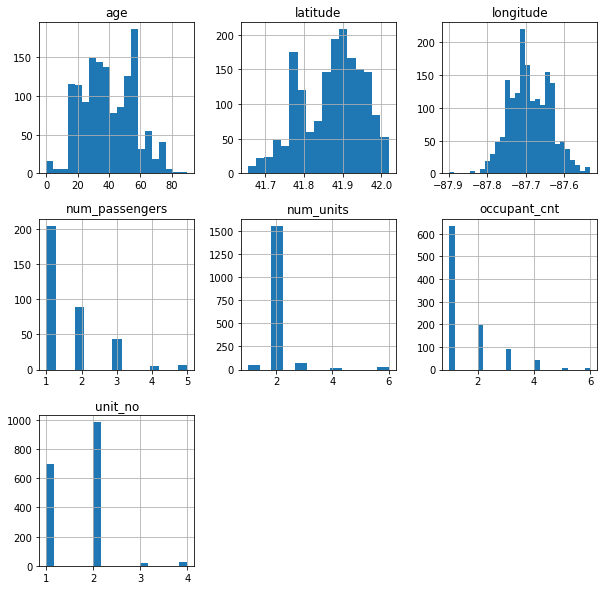

In [24]:
# observing histograms for data 
df.hist(bins='auto', figsize=(10,10))

# Train-Test-Split


In [322]:
# setting X, y for train-test-split
target = 'Injured'
X = df.drop(columns= target)
y = df[target]

# train-test-split, test_size = 25%, random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42)
X_train

,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,roadway_surface_cond,road_defect,hit_and_run_i,beat_of_occurrence,crash_hour,crash_day_of_week,unit_type,vehicle_type,sex,age,safety_equipment,airbag_deployed,driver_vision,pedpedal_visibility
1036,30,TRAFFIC SIGNAL/SIGN,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING/ANGLE,FOUR WAY,DRY,NO DEFECTS,Y,523,23,3,DRIVER,PASSENGER,F,28.0,SAFETY BELT USED,"DEPLOYED, COMBINATION",NaN,NaN
757,30,UNKNOWN/OTHER,NOT FUNCTIONING/UNKNOWN,RAIN/CLOUDY/OTHER,DAYLIGHT,PED/CYCLIST,DIVIDED,WET,UNKNOWN/OTHER,N,932,13,2,PEDESTRIAN,NaN,M,55.0,SAFETY BELT NOT USED,NaN,NOT OBSCURED,NO CONTRASTING CLOTHING
589,30,NO CONTROLS,NO CONTROLS,RAIN/CLOUDY/OTHER,DAWN,PED/CYCLIST,NOT DIVIDED,DRY,UNKNOWN/OTHER,NaN,1712,18,2,BICYCLE,NaN,F,34.0,NONE PRESENT,NaN,NaN,CONTRASTING CLOTHING
907,30,TRAFFIC SIGNAL/SIGN,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING/ANGLE,NOT DIVIDED,DRY,NO DEFECTS,NaN,2533,14,4,DRIVER,PASSENGER,M,23.0,SAFETY BELT USED,DID NOT DEPLOY,NOT OBSCURED,NaN
1159,15,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,PARKING LOT,DRY,NO DEFECTS,NaN,131,17,3,DRIVER,PASSENGER,M,NaN,USAGE UNKNOWN,NOT APPLICABLE,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,30,TRAFFIC SIGNAL/SIGN,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,SIDESWIPE,NOT DIVIDED,DRY,NO DEFECTS,NaN,2521,18,3,DRIVER,PASSENGER,F,NaN,SAFETY BELT USED,DID NOT DEPLOY,NOT OBSCURED,NaN
1294,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED/FIXED,NOT DIVIDED,DRY,NO DEFECTS,NaN,314,14,3,PARKED,OTHER,M,56.0,USAGE UNKNOWN,NOT APPLICABLE,NaN,NaN
860,30,TRAFFIC SIGNAL/SIGN,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,DRY,NO DEFECTS,NaN,911,16,4,DRIVER,PASSENGER,M,47.0,USAGE UNKNOWN,"DEPLOYED, COMBINATION",NOT OBSCURED,NaN
1459,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED/FIXED,ONE-WAY,DRY,NO DEFECTS,Y,2534,0,3,DRIVER,PASSENGER,NaN,NaN,USAGE UNKNOWN,"DEPLOYED, FRONT",NaN,NaN


## Preprocessing Numerical 

In [323]:
# retrieving list of numeric columns 
num_cols = df.drop(columns=target).select_dtypes('number').columns.tolist()
num_cols

['age']

In [324]:
# creating a pipeline 
# SimpleImputer will use the median to fill nulls  
# RobustScaler will use the median to scale 
num_transform = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('scale', RobustScaler())])

## Preprocessing Categorical 

In [325]:
# retrieving list of categorical columns 
cat_cols = df.drop(columns=target).select_dtypes('object').columns.tolist()

In [326]:
cat_cols

['posted_speed_limit',
 'traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'first_crash_type',
 'trafficway_type',
 'roadway_surface_cond',
 'road_defect',
 'hit_and_run_i',
 'beat_of_occurrence',
 'crash_hour',
 'crash_day_of_week',
 'unit_type',
 'vehicle_type',
 'sex',
 'safety_equipment',
 'airbag_deployed',
 'driver_vision',
 'pedpedal_visibility']

In [327]:
# creating a pipeline
# SimpleImputer will use strategy 'constant' == 'missing value' input for objects
# OneHotEncoder will scale the categorical data to a binary column
cat_transform = Pipeline([('imputer', SimpleImputer(strategy='constant')),
                         ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

## ColumnTransformer

In [328]:
# combine both pipelines into one using columntransformer 
preprocessing = ColumnTransformer([('num', num_transform, num_cols), 
                                  ('cat', cat_transform, cat_cols)])

#preprocessing  our X_train data and our X_test to use in models 

X_train_tf = preprocessing.fit_transform(X_train)
X_test_tf = preprocessing.transform(X_test)

In [329]:
# accessing categorical columns from pipeline then converting to dataframe
slice_pipe = preprocessing.named_transformers_['cat']
cat_features = slice_pipe.named_steps['encoder'].get_feature_names(cat_cols)
X_train_tf = pd.DataFrame(X_train_tf,columns=[*num_cols, *cat_features])
X_train_tf

,age,posted_speed_limit_0,posted_speed_limit_10,posted_speed_limit_15,posted_speed_limit_20,posted_speed_limit_24,posted_speed_limit_25,posted_speed_limit_30,posted_speed_limit_34,posted_speed_limit_35,posted_speed_limit_40,posted_speed_limit_45,posted_speed_limit_5,posted_speed_limit_55,traffic_control_device_NO CONTROLS,traffic_control_device_TRAFFIC SIGNAL/SIGN,traffic_control_device_UNKNOWN/OTHER,device_condition_FUNCTIONING PROPERLY,device_condition_NO CONTROLS,device_condition_NOT FUNCTIONING/UNKNOWN,device_condition_missing_value,weather_condition_CLEAR,weather_condition_RAIN/CLOUDY/OTHER,weather_condition_missing_value,lighting_condition_DARKNESS,"lighting_condition_DARKNESS, LIGHTED ROAD",lighting_condition_DAWN,lighting_condition_DAYLIGHT,lighting_condition_DUSK,lighting_condition_UNKNOWN,first_crash_type_OTHER,first_crash_type_PARKED/FIXED,first_crash_type_PED/CYCLIST,first_crash_type_REAR END,first_crash_type_SIDESWIPE,first_crash_type_TURNING/ANGLE,first_crash_type_missing_value,trafficway_type_ALLEY/OTHER,trafficway_type_DIVIDED,trafficway_type_FOUR WAY,trafficway_type_NOT DIVIDED,trafficway_type_ONE-WAY,trafficway_type_PARKING LOT,trafficway_type_UNKNOWN,roadway_surface_cond_DRY,roadway_surface_cond_UNKNOWN,roadway_surface_cond_WET,road_defect_NO DEFECTS,road_defect_UNKNOWN/OTHER,hit_and_run_i_N,hit_and_run_i_Y,hit_and_run_i_missing_value,beat_of_occurrence_1013,beat_of_occurrence_1014,beat_of_occurrence_1021,beat_of_occurrence_1022,beat_of_occurrence_1023,beat_of_occurrence_1024,beat_of_occurrence_1031,beat_of_occurrence_1032,beat_of_occurrence_1033,beat_of_occurrence_1113,beat_of_occurrence_1115,beat_of_occurrence_1121,beat_of_occurrence_1122,beat_of_occurrence_1123,beat_of_occurrence_1124,beat_of_occurrence_1131,beat_of_occurrence_1132,beat_of_occurrence_1133,beat_of_occurrence_1134,beat_of_occurrence_1135,beat_of_occurrence_114,beat_of_occurrence_1213,beat_of_occurrence_1214,beat_of_occurrence_1215,beat_of_occurrence_122,beat_of_occurrence_1221,beat_of_occurrence_1222,beat_of_occurrence_1223,beat_of_occurrence_1225,beat_of_occurrence_1232,beat_of_occurrence_1233,beat_of_occurrence_1235,beat_of_occurrence_124,beat_of_occurrence_131,beat_of_occurrence_132,beat_of_occurrence_133,beat_of_occurrence_1411,beat_of_occurrence_1413,beat_of_occurrence_1421,beat_of_occurrence_1422,beat_of_occurrence_1424,beat_of_occurrence_1432,beat_of_occurrence_1434,beat_of_occurrence_1511,beat_of_occurrence_1512,beat_of_occurrence_1513,beat_of_occurrence_1522,beat_of_occurrence_1524,beat_of_occurrence_1531,beat_of_occurrence_1532,beat_of_occurrence_1533,beat_of_occurrence_1611,beat_of_occurrence_1614,beat_of_occurrence_1621,beat_of_occurrence_1622,beat_of_occurrence_1623,beat_of_occurrence_1631,beat_of_occurrence_1632,beat_of_occurrence_1633,beat_of_occurrence_1634,beat_of_occurrence_1654,beat_of_occurrence_1711,beat_of_occurrence_1712,beat_of_occurrence_1713,beat_of_occurrence_1722,beat_of_occurrence_1723,beat_of_occurrence_1724,beat_of_occurrence_1731,beat_of_occurrence_1732,beat_of_occurrence_1733,beat_of_occurrence_1812,beat_of_occurrence_1813,beat_of_occurrence_1814,beat_of_occurrence_1821,beat_of_occurrence_1822,beat_of_occurrence_1824,beat_of_occurrence_1831,beat_of_occurrence_1834,beat_of_occurrence_1912,beat_of_occurrence_1921,beat_of_occurrence_1922,beat_of_occurrence_1923,beat_of_occurrence_1925,beat_of_occurrence_1931,beat_of_occurrence_1932,beat_of_occurrence_1934,beat_of_occurrence_2011,beat_of_occurrence_2012,beat_of_occurrence_2013,beat_of_occurrence_2031,beat_of_occurrence_2032,beat_of_occurrence_2033,beat_of_occurrence_211,beat_of_occurrence_213,beat_of_occurrence_214,beat_of_occurrence_221,beat_of_occurrence_2211,beat_of_occurrence_2212,beat_of_occurrence_2213,beat_of_occurrence_222,beat_of_occurrence_2221,beat_of_occurrence_2222,beat_of_occurrence_2223,beat_of_occurrence_2234,beat_of_occurrence_224,beat_of_occurrence_231,beat_of_occurrence_232,beat_of_occurrence_233,beat_of_occurrence_234,beat_of_occurrence_235,b

## Class Imbalance (SMOTE)

In [330]:
# observing y_train(classes) count 
y_train.value_counts()

0    713
1    583
Name: Injured, dtype: int64

In [331]:
# Using the SMOTE procedure to solve class imbalance problems 
X_train_tf, y_train = SMOTE().fit_resample(X_train_tf, y_train)

In [332]:
# reviewing SMOTE has been implemented 
pd.Series(y_train).value_counts()

0    713
1    713
dtype: int64

# Model 

## Logistic Regression 

In [333]:
# instantiate LogisticRegression 
log_reg = LogisticRegression()

### log_reg Vanilla Model 

In [334]:
# fit the model 
log_reg.fit(X_train_tf, y_train)

# predict
y_pred = log_reg.predict(X_test_tf)

------------------------------------------------------------
Logistic Regression CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       713
           1       0.98      0.95      0.96       713

    accuracy                           0.96      1426
   macro avg       0.97      0.96      0.96      1426
weighted avg       0.97      0.96      0.96      1426



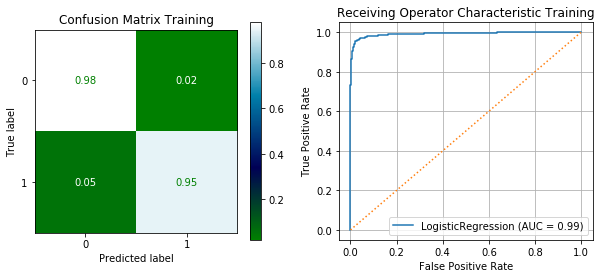

------------------------------------------------------------
Logistic Regression CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       231
           1       0.95      0.92      0.93       201

    accuracy                           0.94       432
   macro avg       0.94      0.94      0.94       432
weighted avg       0.94      0.94      0.94       432



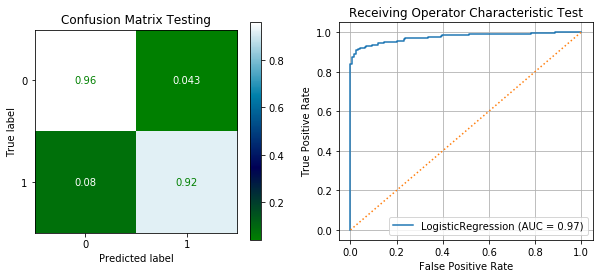

In [335]:
# classification report using function 
evaluate_classification(log_reg,X_train_tf, X_test_tf, y_train, y_test, label = "Logistic Regression")

### log_reg GridsearchCV

In [66]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
f1_scorer = make_scorer(f1_score, pos_label="1")

In [67]:
# create params_grid for LogisticRegression 
params_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'penalty' : ['l1', 'l2', 'elasticnet', None]}
#add random state to params grid


# create grid search 
grid = GridSearchCV(log_reg, params_grid, cv=3, scoring=f1_scorer) 

# fit x_train and y_train to grid 
gridlock = grid.fit(X_train_tf, y_train)

# observe combination of best params 
gridlock.best_params_

{'penalty': 'l1', 'solver': 'liblinear'}

------------------------------------------------------------
Logistic Regression CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       713
           1       0.99      0.97      0.98       713

    accuracy                           0.98      1426
   macro avg       0.98      0.98      0.98      1426
weighted avg       0.98      0.98      0.98      1426



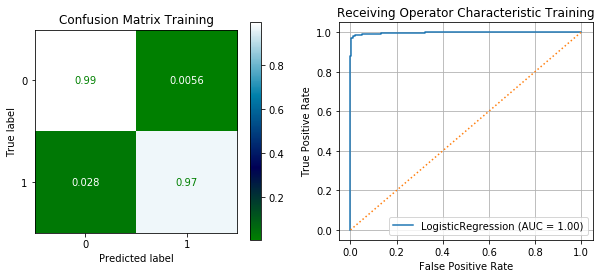

------------------------------------------------------------
Logistic Regression CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       231
           1       0.92      0.92      0.92       201

    accuracy                           0.93       432
   macro avg       0.93      0.93      0.93       432
weighted avg       0.93      0.93      0.93       432



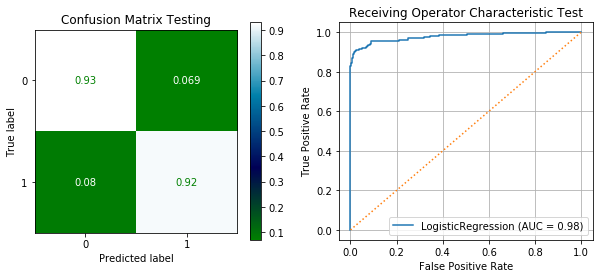

In [39]:
# evaluate model using functioan evaluate_classification and best_params(best_estimator)
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, 
                        label ="Logistic Regression")

## KNN Model 

In [40]:
# instantiate KneighborsClassifier 
knn_clf = KNeighborsClassifier()


### knn_clf Vanilla Model 

In [41]:
# fit the model 
knn_clf.fit(X_train_tf, y_train)

# predict
y_pred = knn_clf.predict(X_test_tf)

------------------------------------------------------------
KNN CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       713
           1       0.93      0.96      0.95       713

    accuracy                           0.94      1426
   macro avg       0.95      0.94      0.94      1426
weighted avg       0.95      0.94      0.94      1426



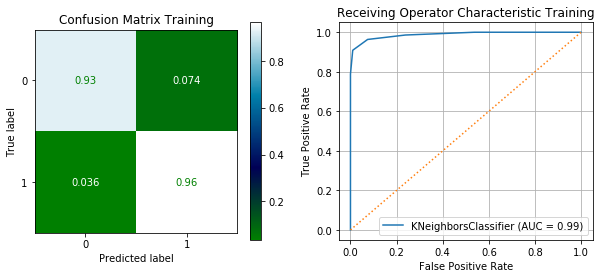

------------------------------------------------------------
KNN CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       231
           1       0.84      0.91      0.87       201

    accuracy                           0.88       432
   macro avg       0.88      0.88      0.87       432
weighted avg       0.88      0.88      0.88       432



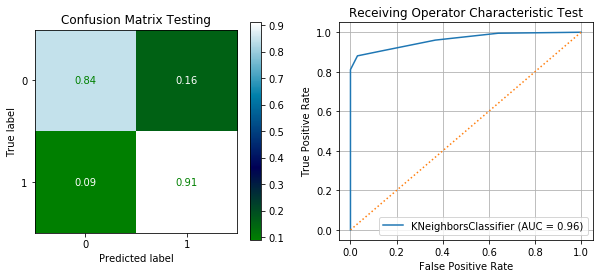

In [42]:
# classification report using function 
evaluate_classification(knn_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'KNN')

### knn_clf GridsearchCV

In [43]:
# create params_grid for KNeighborsClassifier  
params_grid = {'n_neighbors': [3, 5, 7, 9, 11, 21],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

# create grid search 
grid = GridSearchCV(knn_clf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid.fit(X_train_tf, y_train)

# observe combination of best params 
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

------------------------------------------------------------
KNN CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       713
           1       1.00      1.00      1.00       713

    accuracy                           1.00      1426
   macro avg       1.00      1.00      1.00      1426
weighted avg       1.00      1.00      1.00      1426



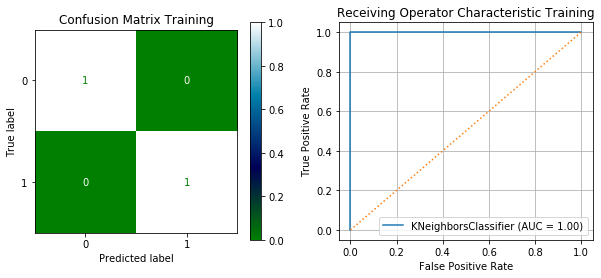

------------------------------------------------------------
KNN CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       231
           1       0.97      0.90      0.93       201

    accuracy                           0.94       432
   macro avg       0.94      0.94      0.94       432
weighted avg       0.94      0.94      0.94       432



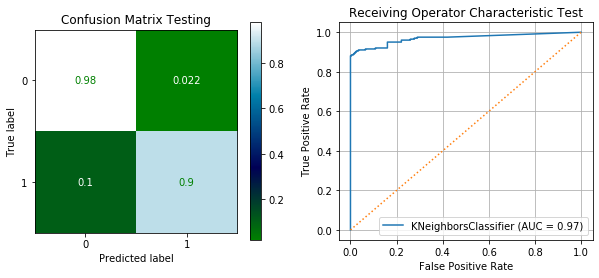

In [44]:
# evaluate model using function evaluate_classification and best_params(best_estimator)
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, label='KNN')

## Decision Tree

In [45]:
# instantiate DecisionTreeClassifier 
tree_clf = DecisionTreeClassifier()

### tree_clf Vanilla Model 

In [46]:
# fit the model  
tree_clf.fit(X_train_tf, y_train)

# predict 
y_pred = tree_clf.predict(X_test_tf)

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       713
           1       1.00      1.00      1.00       713

    accuracy                           1.00      1426
   macro avg       1.00      1.00      1.00      1426
weighted avg       1.00      1.00      1.00      1426



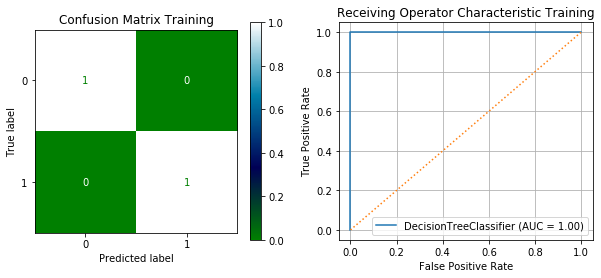

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       231
           1       0.94      0.95      0.94       201

    accuracy                           0.95       432
   macro avg       0.95      0.95      0.95       432
weighted avg       0.95      0.95      0.95       432



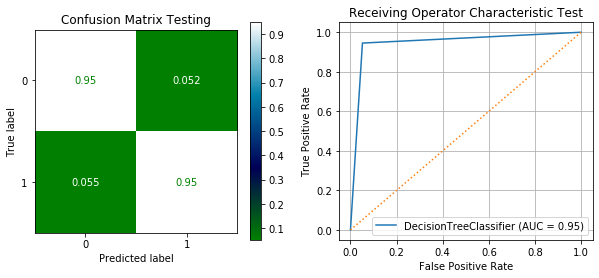

In [47]:
# classification report using function 
evaluate_classification(tree_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'Decision Tree')

### tree_clf GridsearchCV

In [48]:
# create params_grid for DecisionTreeClassifier  
params_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [2,4,6,8,10,12,20, None],
              'min_samples_leaf':[1, 5, 10, 20, 50, 100]}

# create grid search 
grid = GridSearchCV(tree_clf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid.fit(X_train_tf, y_train)

# observe combination of best params 
grid.best_params_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       713
           1       1.00      1.00      1.00       713

    accuracy                           1.00      1426
   macro avg       1.00      1.00      1.00      1426
weighted avg       1.00      1.00      1.00      1426



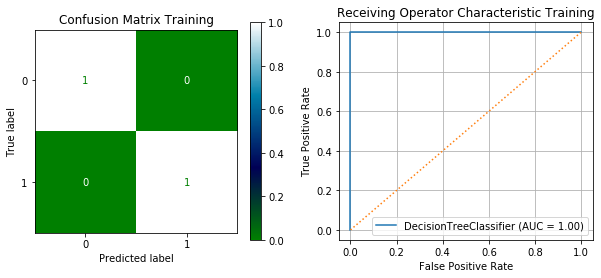

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       231
           1       0.96      0.95      0.95       201

    accuracy                           0.96       432
   macro avg       0.96      0.96      0.96       432
weighted avg       0.96      0.96      0.96       432



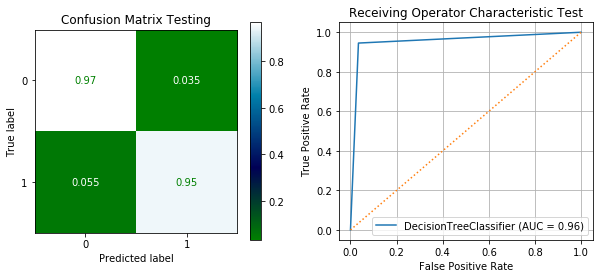

In [49]:
# evaluate model using function evaluate_classification and best_params(best_estimator)
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, 
                        label='Decision Tree')

## Bagged Trees 

In [54]:
# instantiate Bagging + DecisionTreeClassifier  
bag_clf = BaggingClassifier(base_estimator=RandomForestClassifier())

### bag_clf Vanilla Model 

In [55]:
# fit the model  
bag_clf.fit(X_train_tf, y_train)

# predict
y_pred = bag_clf.predict(X_test_tf)

------------------------------------------------------------
Bagged Trees CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       713
           1       1.00      0.98      0.99       713

    accuracy                           0.99      1426
   macro avg       0.99      0.99      0.99      1426
weighted avg       0.99      0.99      0.99      1426



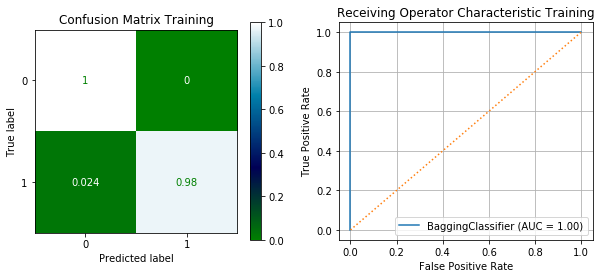

------------------------------------------------------------
Bagged Trees CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       231
           1       1.00      0.85      0.92       201

    accuracy                           0.93       432
   macro avg       0.94      0.93      0.93       432
weighted avg       0.94      0.93      0.93       432



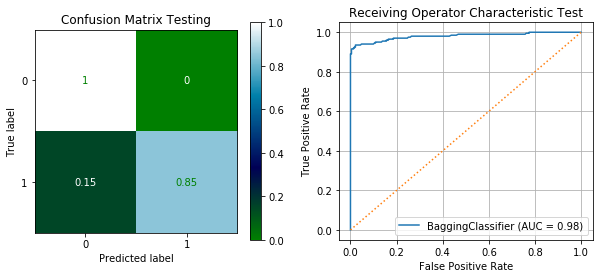

In [56]:
# classification report using function 
evaluate_classification(bag_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'Bagged Trees')

### bag_clf GridsearchCV

In [61]:
# create params_grid for BaggingClassifier
params_grid = {'bootstrap': [True, False],
               'bootstrap_features': [True, False],    
               'n_estimators': [5, 10, 15],
               #'max_samples' : [0.6, 0.8, 1.0],
               'base_estimator__criterion': ['gini', 'entropy'],    
               'base_estimator__max_depth': [1, 5, 10, 15, None]}

# create grid search 
grid = GridSearchCV(bag_clf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid.fit(X_train_tf, y_train)

# observe combination of best params 
grid.best_params_

KeyboardInterrupt: 

In [ ]:
# evaluate model using function evaluate_classification and best_params(best_estimator)
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, 
                        label='Bagged Trees')

## Random Forest 

In [58]:
# instantiate RandomForestClassifier  
forest_clf = RandomForestClassifier()

### forest_clf Vanilla Model 

In [59]:
# fit the model 
forest_clf.fit(X_train_tf, y_train)

# get prediction 
y_pred = forest_clf.predict(X_test_tf)

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       713
           1       1.00      1.00      1.00       713

    accuracy                           1.00      1426
   macro avg       1.00      1.00      1.00      1426
weighted avg       1.00      1.00      1.00      1426



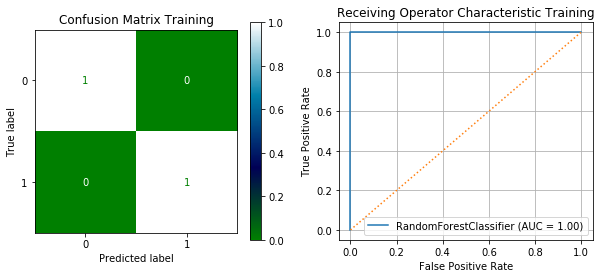

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       231
           1       1.00      0.87      0.93       201

    accuracy                           0.94       432
   macro avg       0.95      0.93      0.94       432
weighted avg       0.94      0.94      0.94       432



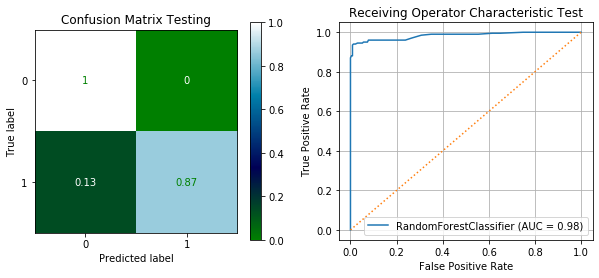

In [60]:
# classification report using function 
evaluate_classification(forest_clf,X_train_tf, X_test_tf, y_train, y_test, label = 'Random Forest')

### forest_clf GridsearchCV

In [ ]:
# create params_grid for RandomForestClassifier 
params_grid = {'criterion': ['gini', 'entropy'],   
              'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [100, 200, 300, 400, 500]}

# create grid search 
grid = GridSearchCV(forest_clf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid.fit(X_train_tf, y_train)

# observe combination of best params 
grid.best_params_

In [ ]:
# evaluate model using function evaluate_classification and best_params(best_estimator)
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, 
                        label='Random Forest')

# iNtrepretation

In [ ]:
# accessing categorical columns from pipeline then converting to dataframe
slice_pipe = preprocessing.named_transformers_['cat']
cat_features = slice_pipe.named_steps['encoder'].get_feature_names(cat_cols)
X_train_tf = pd.DataFrame(X_train_tf,columns=[*num_cols, *cat_features])
X_train_tf

In [ ]:
explainer = shap.TreeExplainer(forest_clf)
shap_values = explainer.shap_values(X_train_tf,y_train)
shap.summary_plot(shap_values,X_train_tf,plot_type='bar')

In [ ]:
shap_values = shap.TreeExplainer(tree_clf).shap_values(X_train_tf)
shap.summary_plot(shap_values, X_train_tf)

In [ ]:
# import sklearn
# from sklearn import svm
# svm = sklearn.svm.SVC(kernel='rbf', probability=True)
# svm.fit(X_train_tf, y_train)
# explainer = shap.KernelExplainer(svm.predict_proba, X_train_tf, link="logit")
# shap_values = explainer.shap_values(X_test_tf, nsamples=10)
# shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test_tf.iloc[0,:], link="logit")

In [ ]:
#shap.dependence_plot('crash_hour_2', shap_values, X_train_tf)

In [ ]:
#shap.TreeExplainer(tree_clf).shap_interaction_values(X_train_tf)

# Conclusion 